In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.tri import Triangulation

import ast

In [3]:
def parse_results(file_name):
    grid_search_results = []
    with open(file_name, 'r') as file:
        for line in file.readlines():
            if line[0:4] == '----':
                grid_search_results.append([])
                continue

            if line[0] == '(':
                fixed_line = '[' + line.strip().replace(') (', '), (') + ']'
                params = ast.literal_eval(fixed_line)
                nested = [list(zip(key.split(','), np.array(val).flatten())) for (key, val) in params]
                unnested = [item for sublist in nested for item in sublist]
                grid_search_results[-1].append({key: val for (key, val) in unnested})
                grid_search_results[-1].append([])
                continue

            result = line

            if result[0] == '[':
                grid_search_results[-1][-1].append(ast.literal_eval(result))
                continue

    grid_search_results = [(params, np.array(values)) for params, values in grid_search_results]
    return grid_search_results

In [73]:
both_res = parse_results('grid_search_results/hyp_wide_100.txt')
# hyp_res = both_res[:len(both_res)//2]
# euc_res = both_res[len(both_res)//2:]
# hyp_res = both_res
# euc_res = both_res
hyp_res = both_res[2::4]
euc_res = both_res[3::4]

In [74]:
hyp_params = np.array([p for p, _ in hyp_res])
hyp_values = np.array([v for _, v in hyp_res])

euc_params = np.array([p for p, _ in euc_res])
euc_values = np.array([v for _, v in euc_res])

hyp_values.shape

(64, 3, 100)

In [75]:
IN_SIZE = 89
OUT_SIZE = 1

NUM_HIDDEN_LAYERS = list(set([p['num_hidden_layers'] for p in hyp_params]).union(set([p['num_hidden_layers'] for p in euc_params])))
LAYER_SIZE = list(set([p['layer_size'] for p in hyp_params]).union(set([p['layer_size'] for p in euc_params])))
LR = list(set([p['lr'] for p in hyp_params]).union(set([p['lr'] for p in euc_params])))
WD = list(set([p['weight_decay'] for p in hyp_params]).union(set([p['weight_decay'] for p in euc_params])))

In [76]:
print(NUM_HIDDEN_LAYERS)
print(LAYER_SIZE)
print(LR)
print(WD)

[0, 1, 4, 16]
[256, 64, 1024, 16]
[0.016, 0.008, 0.004, 0.002]
[0.008, 0.016]


In [77]:
num_hidden_layers = np.array(NUM_HIDDEN_LAYERS).repeat(len(LAYER_SIZE))
layer_size = np.tile(LAYER_SIZE, len(NUM_HIDDEN_LAYERS))

naive_sizes = (num_hidden_layers * layer_size**2).flatten()
real_sizes = (num_hidden_layers * layer_size**2).flatten() + ((np.zeros_like(num_hidden_layers) + (IN_SIZE+OUT_SIZE))*layer_size).flatten()

-1.2506209883532367 -1.3188423240956437
0.03874236044207565 0.03879398269819371


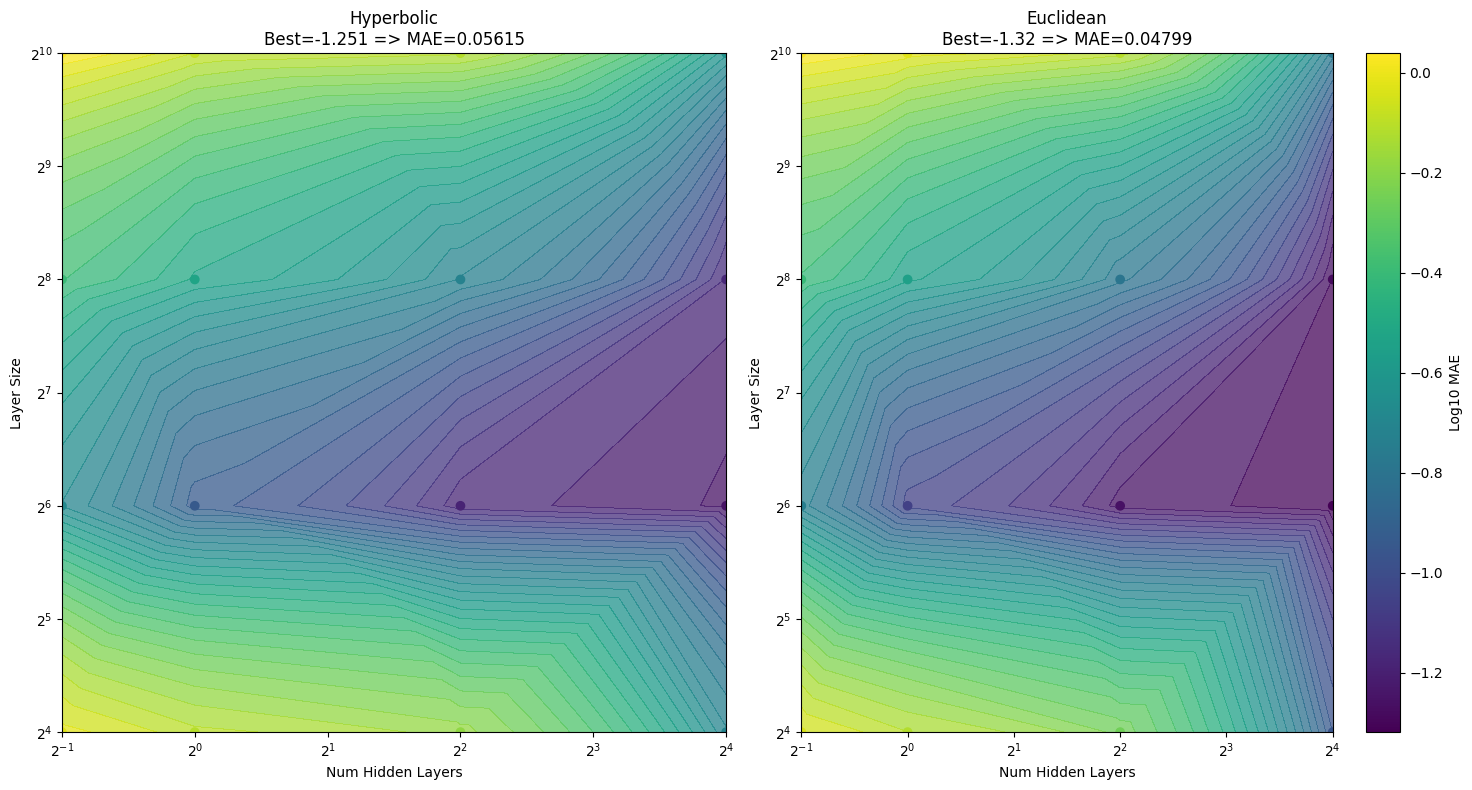

-1.3885113487251206 -1.3638103647499806
0.03940515556282194 0.04057898989536478


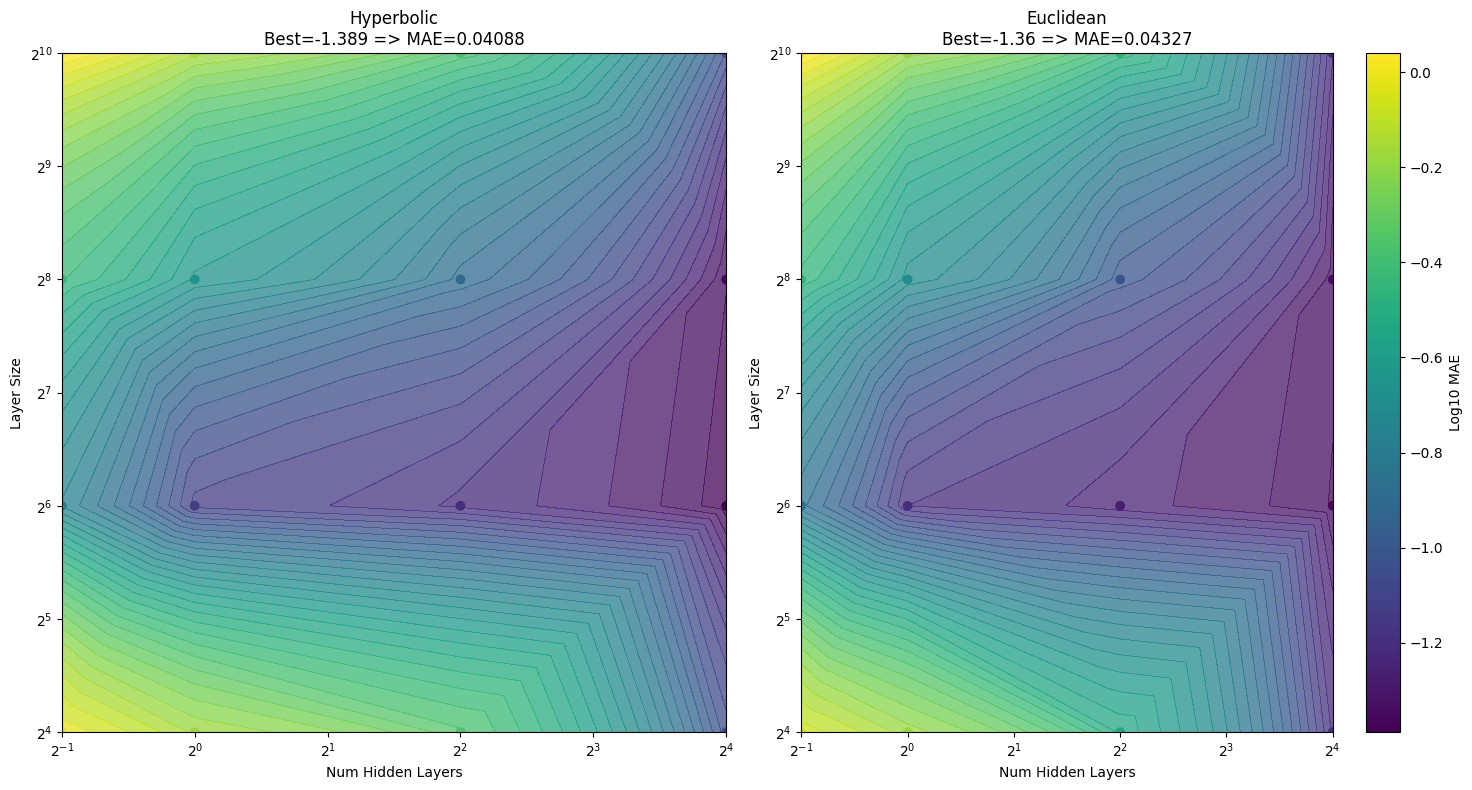

-1.3847888877640104 -1.3796306273680796
0.01573042430415703 -0.0008798012528002053


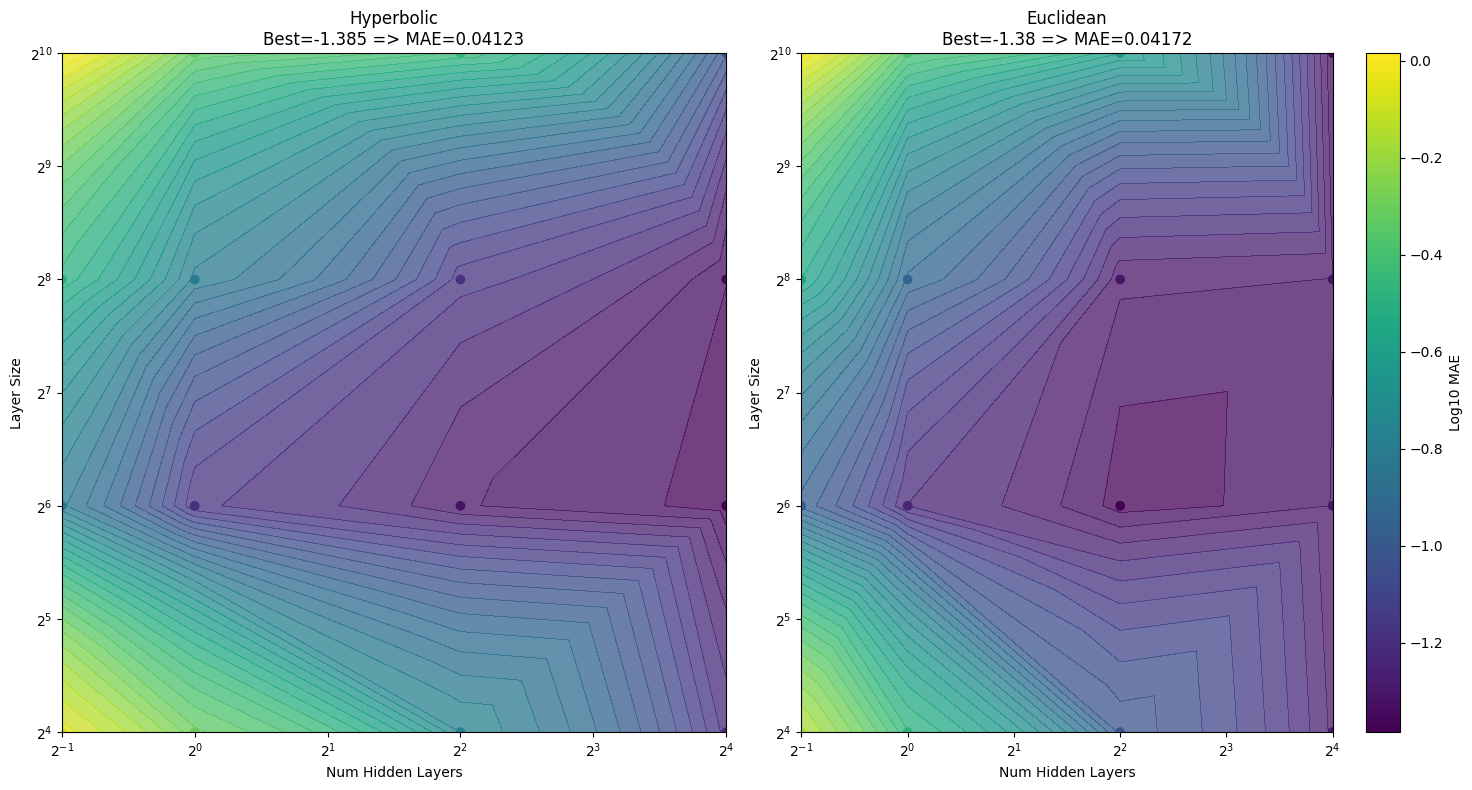

-1.4522862682601536 -1.4239268892984702
-0.09929761800057124 -0.18139065772167765


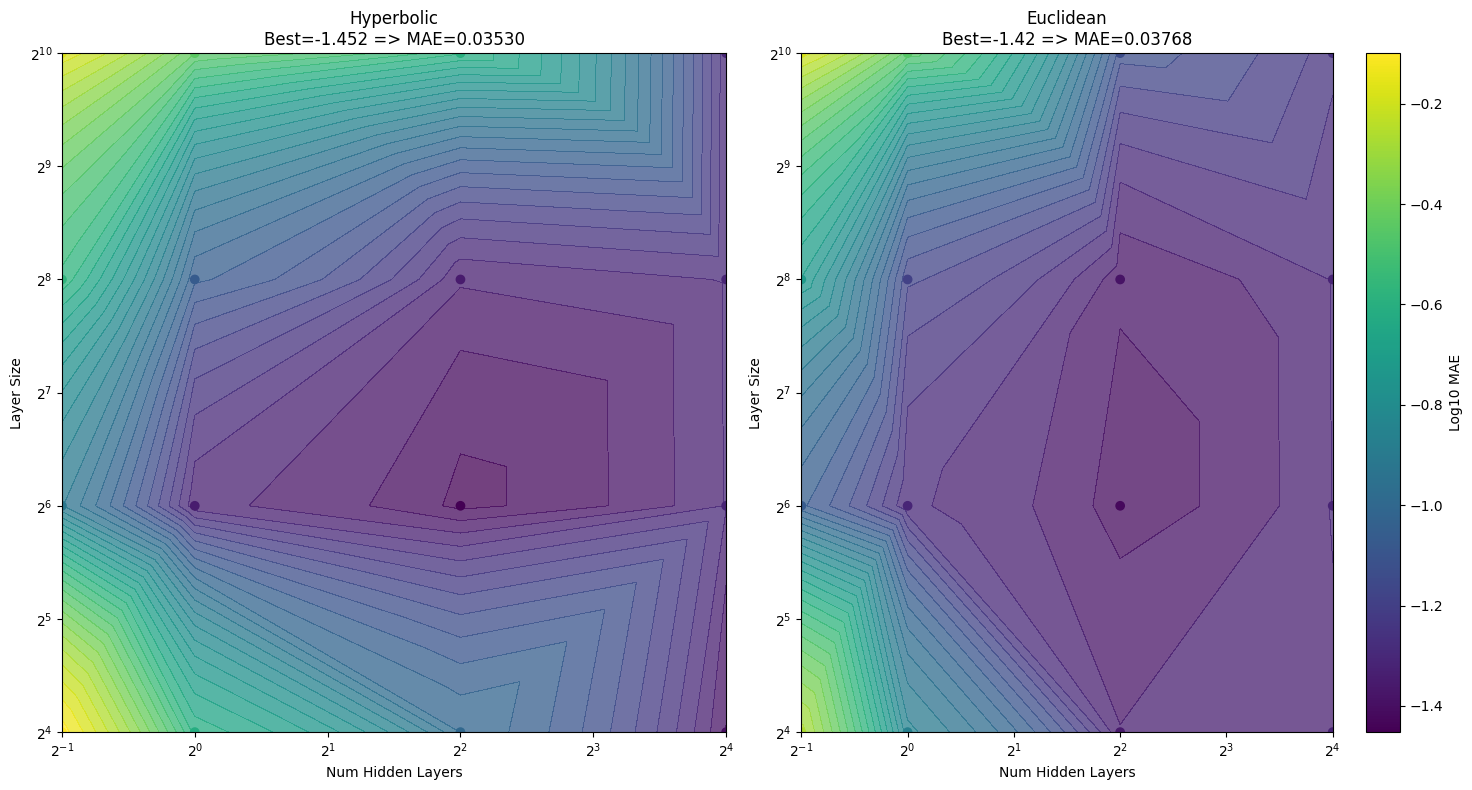

In [78]:
for i, lr in enumerate(LR):
    hyp_data = np.log10(hyp_values.mean(axis=1)[:,-1].reshape(-1,len(LR))[:,i])
    euc_data = np.log10(euc_values.mean(axis=1)[:,-1].reshape(-1,len(LR))[:,i])
    
    min_val = min(np.min(hyp_data), np.min(euc_data))
    max_val = max(np.max(hyp_data), np.max(euc_data))

    print(np.min(hyp_data), np.min(euc_data))
    print(np.max(hyp_data), np.max(euc_data))

    cmap = plt.cm.viridis
    norm = Normalize(vmin=min_val, vmax=max_val)


    num_hidden_layers_adjust = num_hidden_layers.astype(float)
    num_hidden_layers_adjust[num_hidden_layers_adjust == 0] = 0.5

    mesh = Triangulation(num_hidden_layers_adjust, layer_size)  #create tri mesh


    plt.figure(figsize=(15,8))
    # plt.suptitle(f'Hyperbolic     |     Euclidean', fontsize=16, y=1)

    plt.subplot(121)
    plt.tricontourf(mesh, hyp_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
    plt.scatter(num_hidden_layers_adjust, layer_size, c=hyp_data, cmap=cmap, norm=norm)

    plt.title(f'Hyperbolic\nBest={np.min(hyp_data):.3f} => MAE={np.power(10, np.min(hyp_data)):.5f}')
    plt.xlabel('Num Hidden Layers')
    plt.ylabel('Layer Size')

    plt.xscale('log', base=2)
    plt.yscale('log', base=2)


    plt.subplot(122)
    euc_contourf = plt.tricontourf(mesh, euc_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
    euc_scatter = plt.scatter(num_hidden_layers_adjust, layer_size, c=euc_data, cmap=cmap, norm=norm)
    plt.colorbar(euc_scatter, label='Log10 MAE')


    plt.title(f'Euclidean\nBest={np.min(euc_data):.3} => MAE={np.power(10, np.min(euc_data)):.5f}')
    plt.xlabel('Num Hidden Layers')
    plt.ylabel('Layer Size')

    plt.xscale('log', base=2)
    plt.yscale('log', base=2)

    plt.tight_layout()
    plt.show()

<h3>Best Runs:</h3>

Hyperbolic:  MAE = 0.035 (100 EPOCHS)
- num-l:  4
- size-l: 16
- lr: 0.016
- wd: 0.008

Euclidean: ?

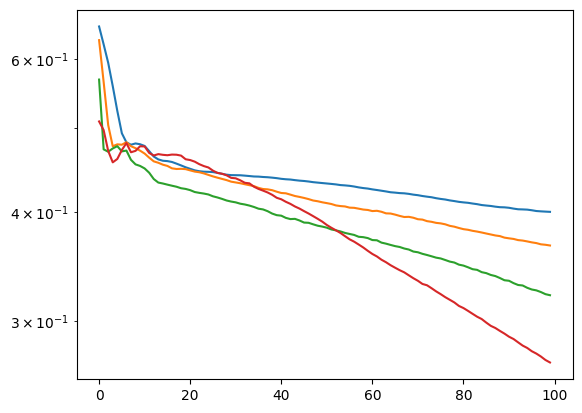

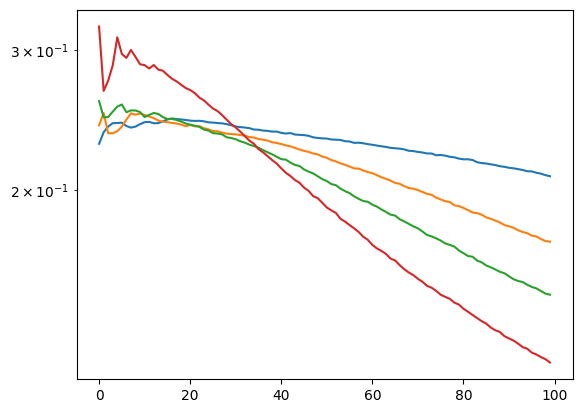

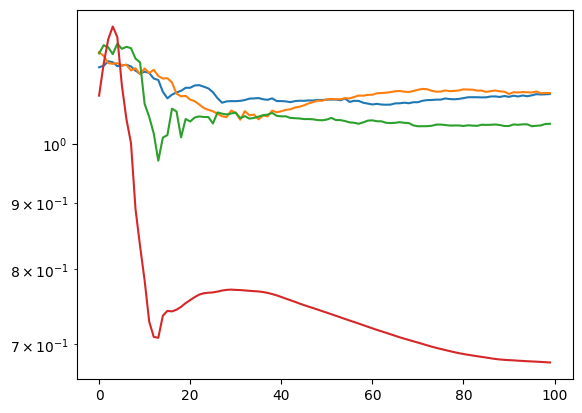

In [53]:
# hyp_min = (0, 1, -1)
# euc_min = (0, 1, -1)
# for i in range(28):
#     plt.plot(hyp_values.mean(axis=1)[i])
#     plt.plot(euc_values.mean(axis=1)[i])

#     print(i)
#     print(hyp_values.mean(axis=1)[i].min(), hyp_values.mean(axis=1)[i].argmin())
#     print(euc_values.mean(axis=1)[i].min(), euc_values.mean(axis=1)[i].argmin())

#     if hyp_values.mean(axis=1)[i].min() < hyp_min[1]:
#         hyp_min = (i, hyp_values.mean(axis=1)[i].min(), hyp_values.mean(axis=1)[i].argmin())
#     if euc_values.mean(axis=1)[i].min() < euc_min[1]:
#         euc_min = (i, euc_values.mean(axis=1)[i].min(), euc_values.mean(axis=1)[i].argmin())


plt.plot(hyp_values.mean(axis=1)[0])
plt.plot(hyp_values.mean(axis=1)[1])
plt.plot(hyp_values.mean(axis=1)[2])
plt.plot(hyp_values.mean(axis=1)[3])

plt.yscale('log')
plt.show()


plt.plot(hyp_values.mean(axis=1)[4])
plt.plot(hyp_values.mean(axis=1)[5])
plt.plot(hyp_values.mean(axis=1)[6])
plt.plot(hyp_values.mean(axis=1)[7])

plt.yscale('log')
plt.show()


plt.plot(hyp_values.mean(axis=1)[8])
plt.plot(hyp_values.mean(axis=1)[9])
plt.plot(hyp_values.mean(axis=1)[10])
plt.plot(hyp_values.mean(axis=1)[11])

plt.yscale('log')
plt.show()